In [26]:
import pandas as pd
import numpy as np
import time
import math
import random
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('../task2/HS300V2_clean_data/clean_train.csv')
test = pd.read_csv('../task2/HS300V2_clean_data/clean_test.csv')

In [27]:
# timer function
def timeSince(since):
    now = time.time()
    s = now-since
    m = math.floor(s/60)
    s-= m*60
    return '%dm %ds' % (m,s)

In [28]:
def split(train,class_num=2):
    train_process = train.copy()
    class_value=[]
    for i in range(1,class_num+1):
        left = train_process['label'].quantile((i-1)/class_num)
        right = train_process['label'].quantile(i/class_num)
        mid = train_process['label'].quantile((i-0.5)/class_num)
        mask1 = train_process['label']>=left
        mask2 = train_process['label']<right
        mask = mask1 & mask2
        train_process.loc[mask,'label'] = mid
        class_value.append(mid)
    
    # deal with the max value point
    mask = train_process['label'] == right
    train_process.loc[mask,'label'] = mid
    
    # change labels to discrete values
    for i in range(class_num):
        mask = train_process['label']==class_value[i]
        train_process.loc[mask,'label'] = i
        
    train_process['label']=train_process['label'].astype('int64')
    return train_process,class_value

In [29]:
def data_process(data,window,option):
    data = data.sort_values(['stock_code','trade_date'])
    stock_code = list(set(data['stock_code']))
    select_stock_code = []
    
    # select stock that has enough factor time series data
    for i in range(len(stock_code)):
        x = data[data['stock_code']==stock_code[i]]
        if x.shape[0]>=window:
            select_stock_code.append(stock_code[i])
    
    # for testing set, record factor time series data, predictions' corresponding stock_code and trade_date
    if option == 'test':
        list1,list2 = [],[]
        for i in range(len(select_stock_code)):
            x = np.array(data[data['stock_code']==select_stock_code[i]])
            row,col = x.shape
            for j in range(row-window+1):
                list1.append(x[j:j+window,2:])
                list2.append(x[j+window-1,:2])
        test_X = torch.tensor(np.array(list1),dtype=torch.float32)
        test_info = torch.tensor(np.array(list2),dtype=torch.int64)
        return test_X,test_info
    
    # for training set or validation set, record factor time series data and predictions
    else:
        list1,list2 = [],[]
        for i in range(len(select_stock_code)):
            x = np.array(data[data['stock_code']==select_stock_code[i]])
            row,col = x.shape
            for j in range(row-window+1):
                list1.append(x[j:j+window,3:])
                list2.append(x[j+window-1,2])
        X = torch.tensor(np.array(list1),dtype=torch.float32)
        y = torch.tensor(np.array(list2),dtype=torch.int64)
        return X,y

In [30]:
class LSTM_classify(nn.Module):
    def __init__(self,num_classes,input_size,hidden_size,num_layers,seq_length):
        super(LSTM_classify,self).__init__()
        
        # num_classes equals to output_size
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,
                           num_layers=num_layers,batch_first=True,dropout=0.5)
        self.fc1 = nn.Linear(hidden_size,128)
        self.fc2 = nn.Linear(128,num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
    
    
    # define many to one lstm framework
    def forward(self,x):
        
        h_0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers,x.size(0),self.hidden_size))
        output,(hn,cn) = self.lstm(x,(h_0,c_0))
        hn = hn[-1:].view(-1,self.hidden_size)
        
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [31]:
class_num = 2
train_process,class_value = split(train,class_num)

In [32]:
# check the labels
np.array(list(set(train_process['label'])))

array([0, 1])

In [33]:
# 95% data as a training set, 5% data as a validation set
num = len(list(set(train_process['trade_date'])))
split_date = math.floor(num*0.95)+1215
train_all = train_process[train_process['trade_date']<=split_date]
valid_all = train_process[train_process['trade_date']>split_date]

In [34]:
window = 10
train_X,train_y = data_process(train_all,window,'train')
valid_X,valid_y = data_process(valid_all,window,'valid')
test_X,test_info = data_process(test,window,'test')

In [35]:
# check the shape of tensor
print(train_X.shape,train_y.shape,valid_X.shape,valid_y.shape,test_X.shape,test_info.shape)

torch.Size([591707, 10, 282]) torch.Size([591707]) torch.Size([29103, 10, 282]) torch.Size([29103]) torch.Size([105135, 10, 282]) torch.Size([105135, 2])


In [112]:
factor_num = train.shape[1]-3
epochs = 5
learning_rate = 1e-3
batch_size = 2048

In [113]:
train_dataset = Data.TensorDataset(train_X,train_y)
valid_dataset = Data.TensorDataset(valid_X,valid_y)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
valid_loader = Data.DataLoader(dataset=valid_dataset,batch_size=batch_size,shuffle=True)

In [114]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
#def __init__(self,num_classes,input_size,hidden_size,num_layers,seq_length):
model = LSTM_classify(class_num,factor_num,32,1,window).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()

epoch 1 time: 0m 27s
epoch 2 time: 0m 50s
epoch 3 time: 1m 12s
epoch 4 time: 1m 38s
epoch 5 time: 2m 7s


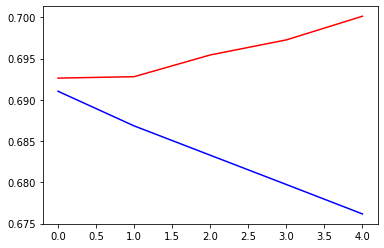

In [115]:
start = time.time()
train_loss = []
valid_loss = [] 
train_epoch_loss = 0
valid_epoch_loss = 0
valid_min_loss = float('inf')
for epoch in range(epochs):
    model.train()
    for t_batch_idx,(t_inputs,t_labels) in enumerate(train_loader):
        t_inputs,t_labels = t_inputs.to(device),t_labels.to(device)
        t_pred = model(t_inputs)
        t_loss = criterion(t_pred.squeeze(1),t_labels)
        optimizer.zero_grad()
        t_loss.backward()
        optimizer.step()
        train_epoch_loss+=t_loss.item()
    
    model.eval()
    for v_batch_idx,(v_inputs,v_labels) in enumerate(valid_loader):
        v_inputs,v_labels = v_inputs.to(device),v_labels.to(device)
        v_pred = model(v_inputs)
        v_loss = criterion(v_pred.squeeze(1),v_labels)
        valid_epoch_loss+=v_loss.item()
            
    
    train_loss.append(train_epoch_loss/(t_batch_idx+1))
    
    # early stop 
    valid_avg_loss = valid_epoch_loss/(v_batch_idx+1)
    if valid_avg_loss/valid_min_loss>1.05:
        break
    else:
        valid_loss.append(valid_avg_loss)
        valid_min_loss = min(valid_loss)
    train_epoch_loss = 0
    valid_epoch_loss = 0 
    print('epoch %d time: %s'% (epoch+1,timeSince(start)))
    
plt.figure()
plt.plot(train_loss,'b-',valid_loss,'r-')
plt.show()

In [116]:
temp = model.cpu()(test_X)
val,idx = temp.max(1)
test_y = torch.zeros(idx.shape[0],1)
for i in range(idx.shape[0]):
    test_y[i]=class_value[idx[i]]
test_y = test_y.detach().numpy()
test_info_np = test_info.numpy().astype(np.int64)

In [117]:
pred = []
for i in range(test_y.shape[0]):
     pred.append([str(test_info_np[i][1]),str(test_info_np[i][0]),str(test_y[i][0])])

In [118]:
pred

[['3411', '0', '0.012257789'],
 ['3412', '0', '-0.013666096'],
 ['3413', '0', '0.012257789'],
 ['3414', '0', '0.012257789'],
 ['3415', '0', '-0.013666096'],
 ['3416', '0', '0.012257789'],
 ['3417', '0', '0.012257789'],
 ['3418', '0', '0.012257789'],
 ['3419', '0', '0.012257789'],
 ['3420', '0', '0.012257789'],
 ['3421', '0', '-0.013666096'],
 ['3422', '0', '-0.013666096'],
 ['3423', '0', '-0.013666096'],
 ['3424', '0', '-0.013666096'],
 ['3425', '0', '-0.013666096'],
 ['3426', '0', '-0.013666096'],
 ['3427', '0', '-0.013666096'],
 ['3428', '0', '-0.013666096'],
 ['3429', '0', '0.012257789'],
 ['3430', '0', '0.012257789'],
 ['3431', '0', '0.012257789'],
 ['3432', '0', '-0.013666096'],
 ['3433', '0', '-0.013666096'],
 ['3434', '0', '-0.013666096'],
 ['3435', '0', '0.012257789'],
 ['3436', '0', '-0.013666096'],
 ['3437', '0', '-0.013666096'],
 ['3438', '0', '-0.013666096'],
 ['3439', '0', '-0.013666096'],
 ['3440', '0', '-0.013666096'],
 ['3441', '0', '-0.013666096'],
 ['3442', '0', '-0.0

In [119]:
from BenchmarkTestTool import submit_benchmark_test

data = pred
submitter = "qiuyuan"
dataset = "HS300V2"
comment = 'LSTM-classify'
submit_benchmark_test(submitter,data,dataset,comment,submit=False)

TEST STATUS: success
************************************************************
COMPLETENESS CHECK
************************************************************
average_daily_miss_num:  59
max_miss_day:  3408
max_miss_day_num:  300
max_miss_stock:  3337
max_miss_stock_num:  25
pred_miss_num:  3092
pred_miss_ratio:  0.0286
pred_num:  105135
true_num:  108227

************************************************************
SUBMIT SIGNAL PERFORMANCE
************************************************************
autocorrelation:  0.5781825433197397
comment:  LSTM-classify
dataset:  HS300V2
pearson:  0.031616891395347825
pearson_250:  0.028775897155439233
pearson_decay:  2.2070253204152307e-05
pearson_std:  0.06285832641920301
sid:  2a04ea1ade70aa8d6a200a700341045c
spearman:  0.04015649029843803
submit_time:  2021-05-12 03:28:49.919871
submitter:  qiuyuan
top30_win_rate:  0.49102927289896126

************************************************************
MODEL SCORE'S EXPOSURE ON RISKS AND INDUST